* https://www.kaggle.com/farelarden/mushroom-classification-100-accuracy
* https://www.kaggle.com/zhunqiang/bank-loan-default-prediction#Create-X,-y,-training/testing-set-split

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
data1 = pd.read_csv('../project 6/loan-default-iter2.csv', index_col = 'id')

### loss and target col will be predicted 
## Build first model
* Create the Object
* split the data and remove the last two columns
* Create the target col
* we are trying to do the tree and to predict the target col with all the data without splitting them but htis is wrong
* this result is wrong we can not use all the data to predict we have to split the data before we fit 
* This means that you can’t evaluate the predictive performance of a model with the same data you used for training. 
* You need evaluate the model with fresh data that hasn’t been seen by the model before. 
* You can accomplish that by splitting your dataset before you use it.
* https://realpython.com/train-test-split-python-data/
* we split it to a train data and test data 
# Over fitting and under fitting
* https://realpython.com/train-test-split-python-data/
* https://realpython.com/linear-regression-in-python/#underfitting-and-overfitting
# DATA
* Now we work on the original data we repeat the obove steps but we do not drop the missing values we replace them by the mean.
* then we split the data to train set and test set
#### Categorize the target variable  


In [3]:
# creat a new column to transform the loss col
def convert_to_categorical(col):
    if col == 0:
        return 0  # paid
    else:
        return 1  # not paid
data1['target'] = data1['loss'].apply(convert_to_categorical)

####  Look if there is a pattern between the paid and not the paid according to the missing values

In [4]:
data1['miss_values'] = data1.isnull().any(axis=1)

def convert_to_categorical(col): 
    if col == 0: 
        return 0 
    else: 
        return 1

data1['target'] = data1['loss'].apply(convert_to_categorical)

data1.value_counts(['target','miss_values']) # true has missing values 

target  miss_values
0       False          62262
        True           10441
1       False           6446
        True             851
dtype: int64

In [5]:
# proportion of paid
10441 /( 10441 + 62262)

0.14361168039833294

In [6]:
# proportion of not paid
851 / (6446 + 851)

0.11662326983691929

* They are very close to each other they have no pattern so the best way is just drop them
# Drop nan and col that have only zero values

In [7]:
data1.dropna(axis=0, inplace=True) 

In [8]:
(data1 == 0).sum() == data1.shape[0]

f1             False
f2             False
f3             False
f4             False
f5             False
               ...  
f99            False
f100           False
loss           False
target         False
miss_values     True
Length: 101, dtype: bool

In [9]:
data11 = data1.loc[:, (data1 != 0).any(axis=0)]

# Solve the problem of imbalance in the classes
* on the target col the paid is 90% the not paid is only 10%
* we chose from the paid a sample that is equal to the not paid data set 

C:\Users\khade_000\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


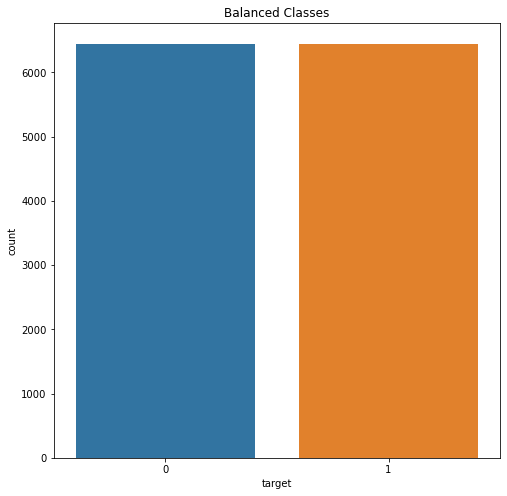

In [10]:
### Shuffle the Dataset.
shuffled_data = data11.sample(frac=1,random_state=42)
shuffled_data

# Put all the not paid class in a separate dataset.
not_paid = shuffled_data.loc[shuffled_data['target'] == 1]
not_paid

#Randomly select 6446(number of not paid rows) observations from the paid (majority class)
paid = shuffled_data.loc[shuffled_data['target'] == 0].sample(n=6446, random_state=42)
paid

# Concatenate both dataframes again
data = pd.concat([paid, not_paid]) # balanced data
data

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('target', data=data)
plt.title('Balanced Classes')
plt.show()

# Check Accuracy Function

In [11]:
# create a function to check the metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

def model_check(y_true, y_pred, model): 
    print('Accuracy :', accuracy_score(y_true, y_pred), '\nRecall :', recall_score(y_true, y_pred))
    
    conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred))
    conf_matrix.set_index(model.classes_, inplace=True)
    conf_matrix.columns = model.classes_
    return conf_matrix

# Plot error Function

In [12]:
def plot_errors(model): 
    X_test_temp = X_test.copy()
    
    plt.subplots(figsize=(12, 8))
    
    X_test_temp = X_test.assign(
        preds = model.predict(X_test), 
        brand = y_test
    )
    X_test_temp['target']=y_test
    sns.scatterplot(data=X_test_temp, x='f64', y='f1', hue='target', alpha=.3)

    errors = X_test_temp.query('preds != target')
    sns.scatterplot(data=errors, x='f64', y='f1', color='red')

    plt.title('Error (red) analysis')
    plt.show()

#  Split the data

In [13]:
# split the data and remove the last two columns
x = data.iloc[:, 0:-2]

# creat the target col
y = data['target']

# Decision Tree

In [14]:
#### Create the tree #####
tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=300, # 300 observations to split
    min_samples_leaf=100 # at each leaf i have 100 customers that have a loan
)

# split the data set
X_train, X_test, y_train, y_test = train_test_split(x,y)

#fit the train set
tree.fit(X_train, y_train) # gives as back an array cahnge them to dataframe

DecisionTreeClassifier(max_depth=3, min_samples_leaf=100, min_samples_split=300)

# Check the Acurracy

To see if the model is overfitted, check if the number of correct predictions is higher on the test set than on the train set. 
You can find out this value by adding the columns predictions and target, and check if they fit by creating a third column. 
Then you can use it to count the values of correct predictions vs uncurrect.
But this approach does not solve the over fitting so we have to do another approach, 
we will play alittle pit with the paramerters in the tree

In [15]:
# train
model_check(y_train, tree.predict(X_train), tree)

Accuracy : 0.6033715999586307 
Recall : 0.501138480645829


,0,1
0,3413,1425
1,2410,2421


In [16]:
# test
model_check(y_test, tree.predict(X_test), tree)

Accuracy : 0.6093701520322681 
Recall : 0.5052631578947369


,0,1
0,1148,460
1,799,816


### Confusion Matrix

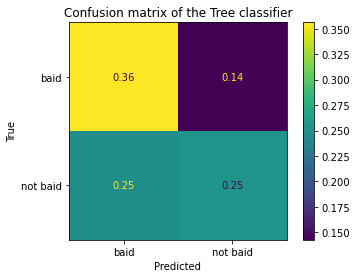

In [17]:
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
plot_confusion_matrix(tree, X_test, y_test, normalize='all',display_labels=['baid','not baid'] )
plt.title('Confusion matrix of the Tree classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve under ClassTree

C:\Users\khade_000\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


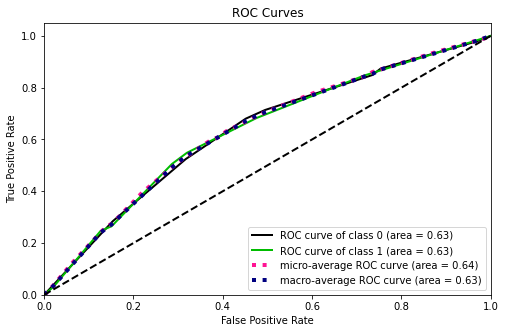

In [18]:
import scikitplot as skplt #to make things easy
y_pred_proba = tree.predict_proba(X_test)   
skplt.metrics.plot_roc_curve(y_test, y_pred_proba, figsize=(8, 5))
plt.show()

In [19]:
probs = pd.DataFrame(tree.predict_proba(X_test)) # 0 is the probability of not paid and 1 is the probability of paid 
probs.head()
min(probs.iloc[:,0])
#max(probs.iloc[:,0])

0.31333333333333335

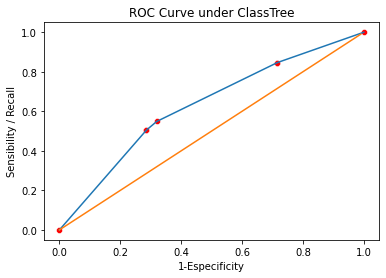

In [20]:
import numpy as np
thresholds = [0.38,0.44, 0.48, 0.50, 0.55]
sensitivities = [1]
especifities_1 = [1]

for t in thresholds: 
    probs['prediction'] = np.where(probs.iloc[:,1] >= t, 1, 0) # we took the 0 col which is the probability of not paid
    probs['actual'] = list(y_test)
    
    y_actu = probs.actual.to_list()
    y_pred = probs.prediction.to_list()


    TN, FP, FN, TP = confusion_matrix(y_actu, y_pred).ravel()
    
   # confusion_matrix = pd.crosstab(probs.prediction, probs.actual)
   # TN=confusion_matrix.iloc[1,1]
   # TP=confusion_matrix.iloc[0,0]
   # FP=confusion_matrix.iloc[0,1]
   # FN=confusion_matrix.iloc[1,0]
    
    sens = TP/(TP+FN)
    sensitivities.append(sens)
    espc_1 = 1-TN/(TN+FP)
    especifities_1.append(espc_1)
    
sensitivities.append(0)
especifities_1.append(0)

sns.lineplot(x=especifities_1, y=sensitivities)
sns.scatterplot(x=especifities_1, y=sensitivities, color='red')
x=[i*0.01 for i in range(100)]
y=[i*0.01 for i in range(100)]
plt.plot(x,y)
plt.xlabel("1-Especificity")
plt.ylabel("Sensibility / Recall")
plt.title("ROC Curve under ClassTree")
plt.show()

In [21]:
# split the data and remove the last two columns
x = data.iloc[:, 0:-2]

# creat the target col
y = data['target']

### Important Features

In [22]:
important_col = pd.DataFrame(tree.feature_importances_, columns=['importance'])

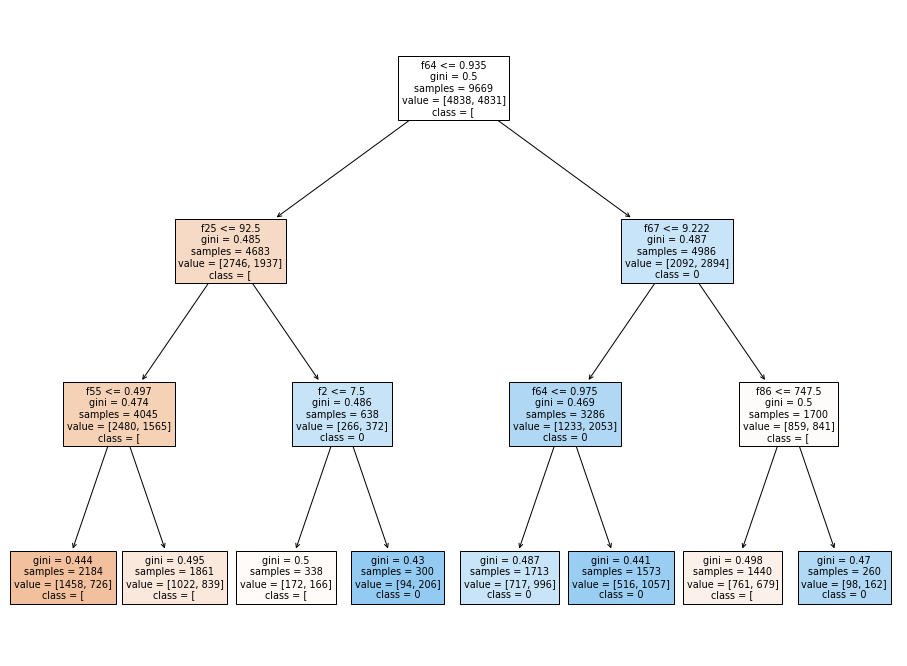

In [23]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
tree = tree.fit(X_train, y_train)
plt.subplots(figsize=(16, 12))
plot_tree(tree, 
          feature_names=x.columns, 
          class_names=str(tree.classes_),
          filled=True # gives the color
)
plt.show()

Text(0, 0.5, 'Variable name')

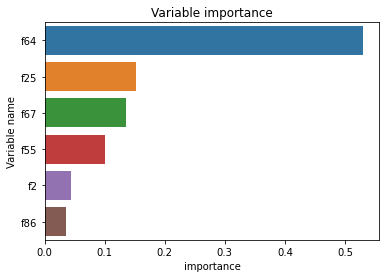

In [24]:
import seaborn as sns

# create a datafrmae based on two columns
#  tree.feature_importances_
#  x_train.columns

var_importance=pd.DataFrame({
    'importance' : tree.feature_importances_,
    'columns' : x.columns    
}).query('importance != 0').sort_values('importance', ascending=False)


sns.barplot(data=var_importance, x='importance', y='columns')
plt.title('Variable importance')
plt.ylabel('Variable name')
 

# KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5) # n_neighbors default = 5

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [26]:
# train 
model_check(y_train, knn.predict(X_train), knn)

Accuracy : 0.7108284207260317 
Recall : 0.7064789898571724


,0,1
0,3460,1378
1,1418,3413


In [27]:
# test
model_check(y_test, knn.predict(X_test), knn)

Accuracy : 0.5069810735339746 
Recall : 0.503405572755418


,0,1
0,821,787
1,802,813


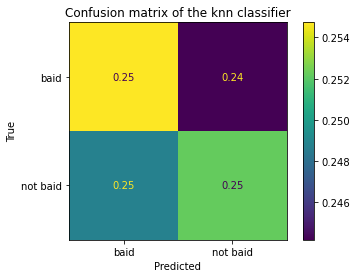

In [28]:
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
plot_confusion_matrix(knn, X_test, y_test, normalize='all',display_labels=['baid','not baid'] )
plt.title('Confusion matrix of the knn classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Normalization Min Max Scale

In [29]:
from sklearn.preprocessing import MinMaxScaler
my_min_max = MinMaxScaler(feature_range=(0,1))
my_min_max.fit(X_train)
X_train_sc = pd.DataFrame(my_min_max.transform(X_train))
X_train_sc.columns = X_train.columns

X_test_sc = pd.DataFrame(my_min_max.transform(X_test))
X_test_sc.columns = X_test.columns

In [30]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_sc, y_train)

KNeighborsClassifier()

In [31]:
# train 
model_check(y_train, knn.predict(X_train_sc), knn)

Accuracy : 0.7101044575447306 
Recall : 0.7329745394328296


,0,1
0,3325,1513
1,1290,3541


In [32]:
# test
model_check(y_test, knn.predict(X_test_sc), knn)

Accuracy : 0.5448340055848588 
Recall : 0.5746130030959752


,0,1
0,828,780
1,687,928


# Confusion Matrix

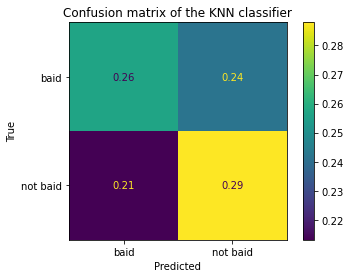

In [33]:
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
plot_confusion_matrix(knn, X_test_sc, y_test, normalize='all',display_labels=['baid','not baid'] )
plt.title('Confusion matrix of the KNN classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Logistic Regrssion

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
lg = LogisticRegression()

lg.fit(X_train, y_train)

LogisticRegression()

In [36]:
# train
model_check(y_train, lg.predict(X_train), lg)

Accuracy : 0.49963801840934946 
Recall : 1.0


,0,1
0,0,4838
1,0,4831


In [37]:
# test
model_check(y_test, lg.predict(X_test), lg)

Accuracy : 0.5010859447719516 
Recall : 1.0


,0,1
0,0,1608
1,0,1615


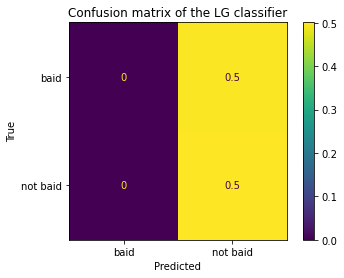

In [38]:
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
plot_confusion_matrix(lg, X_test, y_test, normalize='all',display_labels=['baid','not baid'] )
plt.title('Confusion matrix of the LG classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Normalize

In [39]:
from sklearn.preprocessing import MinMaxScaler
my_min_max = MinMaxScaler(feature_range=(0,1))
my_min_max.fit(X_train)
X_train_sc = pd.DataFrame(my_min_max.transform(X_train))
X_train_sc.columns = X_train.columns

X_test_sc = pd.DataFrame(my_min_max.transform(X_test))
X_test_sc.columns = X_test.columns

In [40]:
lg = LogisticRegression()

lg.fit(X_train_sc, y_train)

C:\Users\khade_000\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
# train
model_check(y_train, lg.predict(X_train_sc), lg)

Accuracy : 0.6266418450718793 
Recall : 0.6452080314634652


,0,1
0,2942,1896
1,1714,3117


In [42]:
# test
model_check(y_test, lg.predict(X_test_sc), lg)

Accuracy : 0.6282966180577102 
Recall : 0.6724458204334365


,0,1
0,939,669
1,529,1086


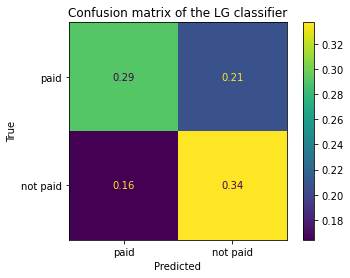

In [43]:
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
plot_confusion_matrix(lg, X_test_sc, y_test, normalize='all',display_labels=['paid','not paid'] )
plt.title('Confusion matrix of the LG classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('CM_lg.png')
plt.show()

In [44]:
probs = pd.DataFrame(lg.predict_proba(X_test)) # 0 is the probability of not paid and 1 is the probability of paid 
probs.head()
min(probs.iloc[:,0])
max(probs.iloc[:,0])

0.0

Machine learning algorithms tend to perform better or converge faster when the different features (variables) are on a smaller scale. 
Therefore it is common practice to normalize the data before training machine learning models on it.

# Random Forest Model
## Advantages
* Random forests is considered as a highly accurate and robust method because of the number of decision trees participating in the process.
* It does not suffer from the overfitting problem. The main reason is that it takes the average of all the predictions, which cancels out the biases.
* The algorithm can be used in both classification and regression problems.
* Random forests can also handle missing values. There are two ways to handle these: using median values to replace continuous variables, and computing the proximity-weighted average of missing values.
* You can get the relative feature importance, which helps in selecting the most contributing features for the classifier.

## Disadvantages
* Random forests is slow in generating predictions because it has multiple decision trees. Whenever it makes a prediction, all the trees in the forest have to make a prediction for the same given input and then perform voting on it. This whole process is time-consuming.
* The model is difficult to interpret compared to a decision tree, where you can easily make a decision by following the path in the tree.



In [45]:
rf = RandomForestClassifier(max_depth=6, random_state=42)

In [46]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [47]:
# train
model_check(y_train, rf.predict(X_train), rf)

Accuracy : 0.675974764711966 
Recall : 0.7099979300351894


,0,1
0,3106,1732
1,1401,3430


In [48]:
# test
model_check(y_test, rf.predict(X_test), rf)

Accuracy : 0.620229599751784 
Recall : 0.6693498452012384


,0,1
0,918,690
1,534,1081


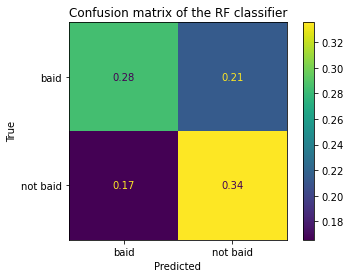

In [49]:
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
plot_confusion_matrix(rf, X_test, y_test, normalize='all',display_labels=['baid','not baid'] )
plt.title('Confusion matrix of the RF classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC of Random Forest

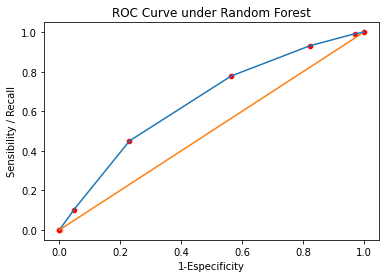

In [50]:
probs = pd.DataFrame(rf.predict_proba(X_test)) # 0 is the probability of not paid and 1 is the probability of paid 
probs.head()
min(probs.iloc[:,0])

max(probs.iloc[:,0])

# we will do the thrsholds with a for loop 

import numpy as np
thresholds = [0.26, 0.36, 0.46, 0.56, 0.65, 0.76, 0.799]
sensitivities = [1]
especifities_1 = [1]

for t in thresholds: 
    probs['prediction'] = np.where(probs.iloc[:,1] >= t, 1, 0) # we took the 0 col which is the probability of not paid
    probs['actual'] = list(y_test)
    
    y_actu = probs.actual.to_list()
    y_pred = probs.prediction.to_list()


    TN, FP, FN, TP = confusion_matrix(y_actu, y_pred).ravel()
    
    #confusion_matrix = pd.crosstab(probs.prediction, probs.actual)
   # TN=confusion_matrix.iloc[1,1]
  #  TP=confusion_matrix.iloc[0,0]
 #   FP=confusion_matrix.iloc[0,1]
#    FN=confusion_matrix.iloc[1,0]
    
    sens = TP/(TP+FN)
    sensitivities.append(sens)
    espc_1 = 1-TN/(TN+FP)
    especifities_1.append(espc_1)
    
sensitivities.append(0)
especifities_1.append(0)

sns.lineplot(x=especifities_1, y=sensitivities)
sns.scatterplot(x=especifities_1, y=sensitivities, color='red')
x=[i*0.01 for i in range(100)]
y=[i*0.01 for i in range(100)]
plt.plot(x,y)
plt.xlabel("1-Especificity")
plt.ylabel("Sensibility / Recall")
plt.title("ROC Curve under Random Forest")
plt.show()

In [51]:
# split the data and remove the last two columns
x = data.iloc[:, 0:-2]

# creat the target col
y = data['target']

C:\Users\khade_000\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


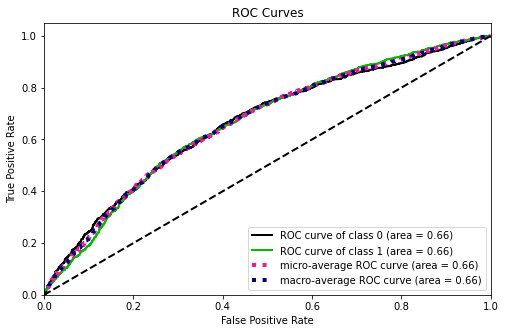

In [52]:
import scikitplot as skplt #to make things easy
y_pred_proba = rf.predict_proba(X_test)   
skplt.metrics.plot_roc_curve(y_test, y_pred_proba, figsize=(8, 5))
plt.show()
#skplt.metrics.plot_precision_recall_curve(y_test, y_pred_proba, figsize=(8, 5))
#plt.show()

# Support Vector Machine

In [53]:
svm = SVC(probability=True)

In [54]:
svm.fit(X_train, y_train)

SVC(probability=True)

In [55]:
# train
model_check(y_train, svm.predict(X_train), svm)

Accuracy : 0.5280794291033198 
Recall : 0.4394535292900021


,0,1
0,2983,1855
1,2708,2123


In [56]:
# test
model_check(y_test, svm.predict(X_test), svm)

Accuracy : 0.5234253800806702 
Recall : 0.4371517027863777


,0,1
0,981,627
1,909,706


In [ ]:
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
plot_confusion_matrix(svm, X_test, y_test,display_labels=['baid','not baid'] )
plt.title('Confusion matrix of the svm classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Apply normalisation

In [58]:
svm = SVC(probability=True)

In [59]:
svm.fit(X_train_sc, y_train)

SVC(probability=True)

In [60]:
# train
model_check(y_train, svm.predict(X_train_sc), svm)

Accuracy : 0.6405005688282139 
Recall : 0.6905402608155662


,0,1
0,2857,1981
1,1495,3336


In [61]:
# test
model_check(y_test, svm.predict(X_test_sc), svm)

Accuracy : 0.6313993174061433 
Recall : 0.7040247678018576


,0,1
0,898,710
1,478,1137


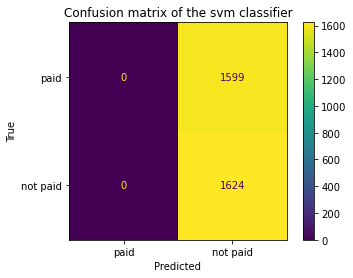

In [121]:
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
plot_confusion_matrix(svm, X_test_sc, y_test, normalize='all',display_labels=['paid','not paid'] )
plt.title('Confusion matrix of the svm classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('CM_svm.png')
plt.show()

# Apply Cross Validation 

In [63]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

In [64]:
# split the data set
X_train, X_test, y_train, y_test = train_test_split(x,y)

In [65]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
my_min_max = MinMaxScaler(feature_range=(0,1))
my_min_max.fit(X_train)
X_train_sc = pd.DataFrame(my_min_max.transform(X_train))
X_train_sc.columns = X_train.columns

X_test_sc = pd.DataFrame(my_min_max.transform(X_test))
X_test_sc.columns = X_test.columns

In [66]:
model_params = {
 #   'svm': {
  #      'model': svm.SVC(gamma='auto'),
  #      'params' : {
  #          'C': [1,10,20],
  #          'kernel': ['rbf','linear']
  #      }  
  #  },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            
        }
    },
    'KNN':{
        'model' : KNeighborsClassifier(n_neighbors=5), 
        'params': {}
    }
}

In [67]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_sc, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
       # 'best_params': clf.best_params_,
      #  'error_score': clf.error_score,
      #  'cv_results': clf.cv_results_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score'])
df

,model,best_score
0,random_forest,0.566554
1,logistic_regression,0.623333
2,decision_tree,0.538112
3,KNN,0.560037


In [68]:
model_params = {
 'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    }
}

In [69]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_sc, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
       # 'best_params': clf.best_params_,
      #  'error_score': clf.error_score,
      #  'cv_results': clf.cv_results_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score'])
df

,model,best_score
0,svm,0.624574


# Scale all the x data

https://www.youtube.com/watch?v=zUqa6KcwRhs&t=960s

In [63]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve

In [64]:
robust_scaler = RobustScaler()
x = robust_scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x,y)

In [65]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], 
                      columns=['LogisticReg', 'KNN', 'ClassTree', 'SVM', 'RandomForest'])

## Some definitions
* **Accuracy**: the proportion of the total number of predictions that are correct
** Overall how often the model predicts correctly not paid and paid customers
* **Precision**: the proportion of positive predictions that are actually correct
** When the model predicts not paid : how often is correct?
* **Recall**: the proportion of positive observed values correctly predicted
** The proportion of actual not paid customres that the model will correctly predict

### The metric:
* **False Positive**: A person who will pay predicted as not pay
* **False Negative**: A person who will not pay predicted as pay

####  False negative are worse => Look for a better recall

## Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)
logistic_regression.fit(X_train, y_train)
y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy', 'LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)


# KNN

In [67]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)
metrics.loc['accuracy', 'KNN'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'KNN'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'KNN'] = recall_score(y_pred=y_pred_test, y_true=y_test)

# ClassTree

In [68]:
from sklearn.tree import DecisionTreeClassifier

class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)
class_tree.fit(X_train, y_train)
y_pred_test = class_tree.predict(X_test)
metrics.loc['accuracy', 'ClassTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'ClassTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'ClassTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)

# SVM

In [69]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_test = svm.predict(X_test)
metrics.loc['accuracy', 'SVM'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'SVM'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'SVM'] = recall_score(y_pred=y_pred_test, y_true=y_test)

# Random Forest

In [70]:
rf = RandomForestClassifier(max_depth=6, random_state=42)
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)
metrics.loc['accuracy', 'RandomForest'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'RandomForest'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'RandomForest'] = recall_score(y_pred=y_pred_test, y_true=y_test)

In [71]:
metrics

,LogisticReg,KNN,ClassTree,SVM,RandomForest
accuracy,0.626745,0.567794,0.548868,0.614645,0.62023
precision,0.62922,0.568465,0.552276,0.605759,0.621803
recall,0.631158,0.590517,0.552956,0.673645,0.628695


In [72]:
100*metrics

,LogisticReg,KNN,ClassTree,SVM,RandomForest
accuracy,62.6745,56.7794,54.8868,61.4645,62.023
precision,62.922,56.8465,55.2276,60.5759,62.1803
recall,63.1158,59.0517,55.2956,67.3645,62.8695


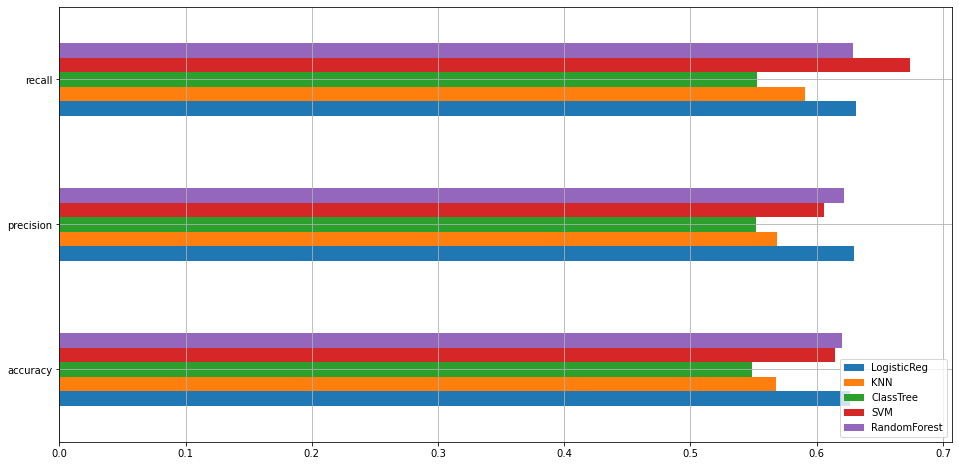

In [73]:
import matplotlib.pyplot as plt
fig, ax=plt.subplots(figsize=(16,8))
metrics.plot(kind='barh', ax=ax)
plt.savefig('apr.png')

ax.grid();

In [74]:
# adjust the recall and precision by modifying the threshold
# svm best recall
# rf best accuracy
precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_true=y_test, 
                                                                  probas_pred=svm.predict_proba(X_test)[:,1])
precision_lg, recall_lg, thresholds_lg = precision_recall_curve(y_true=y_test, 
                                                                  probas_pred=logistic_regression.predict_proba(X_test)[:,1])


#### see the relationship between recall and percision

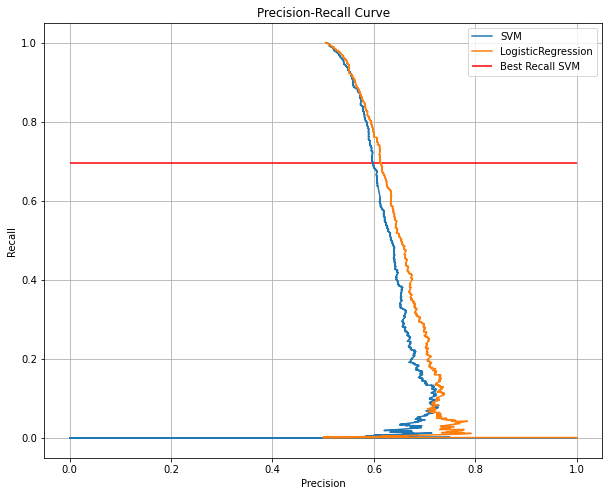

In [75]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(precision_svm, recall_svm, label='SVM')
ax.plot(precision_lg, recall_lg, label='LogisticRegression')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.695917, xmin=0, xmax=1, color='red', label='Best Recall SVM')
ax.legend()
plt.savefig('Pre-rec-curve.png')
ax.grid();

#### SO we need to adjust the classification thesholds for random forest to have better or similar recall as SVM
* we can do that by looking at the relationshop between the thresholds and these two matrix

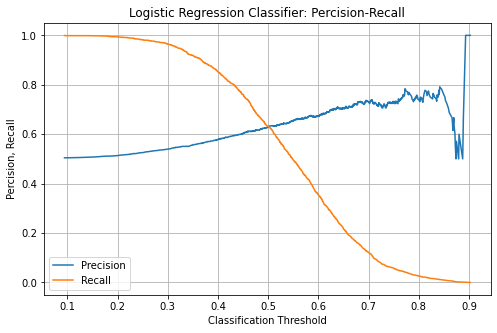

In [120]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds_lg, precision_lg[1:], label='Precision')
ax.plot(thresholds_lg, recall_lg[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Percision, Recall')
ax.set_title('Logistic Regression Classifier: Percision-Recall')
#ax.hlines(y=0.7368, xmin=0, xmax=1, color='red', label='Best Recall_SVM=0.69')
#ax.vlines(x=0.65, ymin=0, ymax=1, color='green', label='Best Thresholds for Lg=0.65')
ax.legend()
plt.savefig('threshods6.png')
ax.grid();

In [84]:
0.451

0.451

# Chose the best threshold for maximum accuracy

In [92]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred=[]
for model in [logistic_regression]:
    pred.append(pd.Series(model.predict_proba(X_test_sc)[:,1]))
final_prediction=pd.concat(pred,axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test,final_prediction)))

Ensemble test roc-auc: 0.5084162053253727


In [93]:
pd.concat(pred,axis=1)

,0
0,0.704028
1,0.657752
2,0.691441
3,0.690683
4,0.686269
...,...
3218,0.644478
3219,0.677137
3220,0.674720
3221,0.728276


In [94]:
final_prediction

0       0.704028
1       0.657752
2       0.691441
3       0.690683
4       0.686269
          ...   
3218    0.644478
3219    0.677137
3220    0.674720
3221    0.728276
3222    0.671448
Length: 3223, dtype: float64

#### Calculate the ROc Curve

In [95]:
fpr, tpr, thresholds = roc_curve(y_test, final_prediction)
thresholds

array([1.79894948, 0.79894948, 0.79036394, ..., 0.60925883, 0.60732607,
       0.59076976])

In [96]:
from sklearn.metrics import accuracy_score
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
511,0.694967,0.516289
502,0.695329,0.516289
503,0.695282,0.515979
510,0.695041,0.515979
508,0.695059,0.515979


In [97]:
accuracy_ls

,thresholds,accuracy
511,0.694967,0.516289
502,0.695329,0.516289
503,0.695282,0.515979
510,0.695041,0.515979
508,0.695059,0.515979
...,...,...
176,0.713079,0.493639
174,0.713181,0.493639
173,0.713224,0.493639
171,0.713266,0.493639


In [98]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

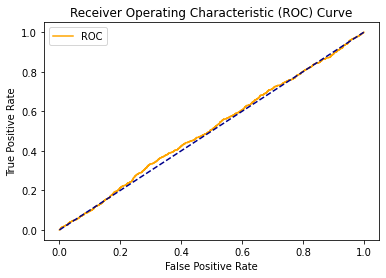

In [99]:
plot_roc_curve(fpr,tpr)

### Classifier with thresholds = 0.451

In [112]:
y_pred_proba = logistic_regression.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.459).astype('int')
print('Recall: ', 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print('Precision: ', 100*precision_score(y_pred=y_pred_test, y_true=y_test))
print('Accuracy: ', 100*accuracy_score(y_pred=y_pred_test, y_true=y_test))



Recall:  73.95320197044335
Precision:  61.08850457782299
Accuracy:  63.13993174061433


In [86]:
def make_ind_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    data = robust_scaler.transform(data)
    prob = rf.predict_proba(data)[0][1]
    if prob >= 0.5:
        return 'Will not pay'
    else:
        return 'Will pay'

In [87]:
pay = data[data['target']==0]

In [88]:
pay.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f93,f94,f95,f96,f97,f98,f99,f100,loss,target
id,,,,,,,,,,,,,,,,,,,,,
34446,159,7,0.611655,4500,4,86032,352.0,102.0,156.57,158.92,...,0.0,0.11,40.0,40.0,40.0,40.0,0.32,1.34,0,0
66784,161,9,0.722108,4400,3,8423,3148.0,1472.0,158.19,161.03,...,0.0,0.09,280.0,280.0,280.0,280.0,0.28,1.45,0,0
79536,163,7,0.507049,5300,3,76635,3467.0,4316.0,157.90,161.90,...,0.0,0.12,417.0,417.0,417.0,417.0,0.33,1.31,0,0
47367,154,7,0.586864,4500,7,82134,5284.0,564.0,155.36,154.05,...,0.0,0.12,643.0,643.0,643.0,643.0,0.33,1.31,0,0
32027,125,7,0.161633,1100,16,82379,1086.0,1773.0,126.08,125.12,...,0.0,0.08,84.0,84.0,84.0,84.0,0.27,1.45,0,0


In [89]:
new_data = data.iloc[2:3, 0:-2]
new_data

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100
id,,,,,,,,,,,,,,,,,,,,,
79536,163,7,0.507049,5300,3,76635,3467.0,4316.0,157.9,161.9,...,1.54,0.01,0.0,0.12,417.0,417.0,417.0,417.0,0.33,1.31


In [90]:
make_ind_prediction(new_data)

'Will not pay'

In [91]:
data.iloc[2:3, 0:-2]

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100
id,,,,,,,,,,,,,,,,,,,,,
79536,163,7,0.507049,5300,3,76635,3467.0,4316.0,157.9,161.9,...,1.54,0.01,0.0,0.12,417.0,417.0,417.0,417.0,0.33,1.31


In [92]:
make_ind_prediction(data.iloc[2:3, 0:-2])

'Will not pay'

In [93]:
data

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f93,f94,f95,f96,f97,f98,f99,f100,loss,target
id,,,,,,,,,,,,,,,,,,,,,
34446,159,7,0.611655,4500,4,86032,352.0,102.0,156.57,158.92,...,0.00,0.11,40.0,40.0,40.0,40.0,0.32,1.34,0,0
66784,161,9,0.722108,4400,3,8423,3148.0,1472.0,158.19,161.03,...,0.00,0.09,280.0,280.0,280.0,280.0,0.28,1.45,0,0
79536,163,7,0.507049,5300,3,76635,3467.0,4316.0,157.90,161.90,...,0.00,0.12,417.0,417.0,417.0,417.0,0.33,1.31,0,0
47367,154,7,0.586864,4500,7,82134,5284.0,564.0,155.36,154.05,...,0.00,0.12,643.0,643.0,643.0,643.0,0.33,1.31,0,0
32027,125,7,0.161633,1100,16,82379,1086.0,1773.0,126.08,125.12,...,0.00,0.08,84.0,84.0,84.0,84.0,0.27,1.45,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52848,126,11,0.457856,1800,16,11255,4163.0,3003.0,126.78,125.98,...,0.00,0.09,390.0,390.0,390.0,390.0,0.29,1.42,3,1
22180,158,8,0.617494,3600,13,80120,1123.0,776.0,150.45,156.42,...,0.09,0.11,125.0,125.0,125.0,125.0,0.31,1.37,4,1
41172,152,8,0.087538,3500,4,13970,4829.0,3764.0,154.10,152.72,...,0.00,0.13,621.0,621.0,621.0,621.0,0.33,1.32,1,1


In [141]:
def make_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    data = robust_scaler.transform(data)
    prob = rf.predict_proba(data)[0][1]
    if prob >= 0.5:
        return 1
    else:
        return 0

In [144]:
dd = data.copy()
for x in dd.index[0:12892]:
    print(x)
    #print(make_ind_prediction(data.loc[x].drop('target').drop('loss')))
    dd['Prediction'] = make_ind_prediction(dd.loc[x].drop('target').drop('loss'))

ValueError: operands could not be broadcast together with shapes (1,94) (93,) (1,94) 

In [145]:
data

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f94,f95,f96,f97,f98,f99,f100,loss,target,Prediction
id,,,,,,,,,,,,,,,,,,,,,
34446,159,7,0.611655,4500,4,86032,352.0,102.0,156.57,158.92,...,0.11,40.0,40.0,40.0,40.0,0.32,1.34,0,0,1
66784,161,9,0.722108,4400,3,8423,3148.0,1472.0,158.19,161.03,...,0.09,280.0,280.0,280.0,280.0,0.28,1.45,0,0,1
79536,163,7,0.507049,5300,3,76635,3467.0,4316.0,157.90,161.90,...,0.12,417.0,417.0,417.0,417.0,0.33,1.31,0,0,1
47367,154,7,0.586864,4500,7,82134,5284.0,564.0,155.36,154.05,...,0.12,643.0,643.0,643.0,643.0,0.33,1.31,0,0,1
32027,125,7,0.161633,1100,16,82379,1086.0,1773.0,126.08,125.12,...,0.08,84.0,84.0,84.0,84.0,0.27,1.45,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52848,126,11,0.457856,1800,16,11255,4163.0,3003.0,126.78,125.98,...,0.09,390.0,390.0,390.0,390.0,0.29,1.42,3,1,1
22180,158,8,0.617494,3600,13,80120,1123.0,776.0,150.45,156.42,...,0.11,125.0,125.0,125.0,125.0,0.31,1.37,4,1,1
41172,152,8,0.087538,3500,4,13970,4829.0,3764.0,154.10,152.72,...,0.13,621.0,621.0,621.0,621.0,0.33,1.32,1,1,1


In [148]:
data['target']==data['Prediction']

id
34446    False
66784    False
79536    False
47367    False
32027    False
         ...  
52848     True
22180     True
41172     True
47981     True
35989     True
Length: 12892, dtype: bool

In [157]:
#data['Prediction'== 1].sum()
data.value_counts(['Prediction']) # true has missing values 

Prediction
1             12892
dtype: int64

In [159]:
data['Prediction']

id
34446    1
66784    1
79536    1
47367    1
32027    1
        ..
52848    1
22180    1
41172    1
47981    1
35989    1
Name: Prediction, Length: 12892, dtype: int64

In [216]:
for c in range(len(data)):
    print(c)
    data['forecast'] = make_ind_prediction(data.iloc[c+2:c+3, 0:-3])
    

0
1


ValueError: operands could not be broadcast together with shapes (1,93) (92,) (1,93) 

In [196]:
d = pd.DataFrame(data.loc[8375]).transpose


<bound method DataFrame.transpose of                8375
f1       122.000000
f2         6.000000
f3         0.922235
f4      1800.000000
f5         4.000000
...             ...
f98      144.000000
f99        0.320000
f100       1.340000
loss       0.000000
target     0.000000

[95 rows x 1 columns]>

In [189]:
make_ind_prediction(d)

ValueError: operands could not be broadcast together with shapes (1,95) (92,) (1,95) 

In [201]:

for x in data.index[0:100]:
    print(x)
    data['pre'] = make_ind_prediction(data.loc[x])

8375


ValueError: operands could not be broadcast together with shapes (1,95) (92,) (1,95) 

In [ ]:
def make_ind_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    data = robust_scaler.transform(data)
    prob = logistic_regression.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'Will not pay'
    else:
        return 'Will pay'
data1['predict'] = data1[data1.iterrows()]

ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,92)

In [138]:
not_paid.iloc[:,0:-3]

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
id,,,,,,,,,,,,,,,,,,,,,
4580,148,8,0.698982,3500,1,83293,318.0,17.0,149.93,148.36,...,1.29,1.54,0.51,0.90,0.10,32.0,32.0,32.0,32.0,0.30
39875,127,9,0.755879,1900,17,76831,4440.0,2929.0,126.97,127.06,...,1.46,1.81,0.04,0.00,0.08,356.0,356.0,356.0,356.0,0.27
56149,160,7,0.455796,3500,10,80135,2666.0,6414.0,157.65,159.41,...,1.35,1.62,0.01,0.00,0.12,321.0,321.0,321.0,321.0,0.33
66732,126,10,0.232903,1300,16,81679,963.0,1592.0,124.84,125.78,...,1.36,1.65,0.01,0.00,0.09,89.0,89.0,89.0,89.0,0.29
28121,129,8,0.008847,1300,16,78,4806.0,1661.0,127.25,128.63,...,1.49,1.86,0.26,0.09,0.08,393.0,393.0,393.0,393.0,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75608,153,8,0.072143,4500,3,76025,3778.0,4178.0,152.17,152.79,...,1.29,1.54,0.01,0.00,0.12,465.0,465.0,465.0,465.0,0.33
36819,155,7,0.222231,3600,3,76635,464.0,3912.0,155.95,155.12,...,1.25,1.48,0.13,0.01,0.10,45.0,45.0,45.0,45.0,0.30
16844,133,8,0.095177,1500,4,79582,2266.0,2651.0,128.44,132.10,...,1.25,1.48,0.01,0.00,0.12,269.0,269.0,269.0,269.0,0.32
